<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Примечание" data-toc-modified-id="Примечание-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><strong>Примечание</strong></a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Сначала-проверим,-какое-значение-f1-выдают-данные-БЕЗ-учета-баланса" data-toc-modified-id="Сначала-проверим,-какое-значение-f1-выдают-данные-БЕЗ-учета-баланса-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Сначала проверим, какое значение f1 выдают данные БЕЗ учета баланса</a></span></li><li><span><a href="#С-учетом-баланса" data-toc-modified-id="С-учетом-баланса-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>С учетом баланса</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Финальное-тестирование" data-toc-modified-id="Финальное-тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Финальное тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Описание проекта

**Проект для «Викишоп»**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества `F1` не меньше **0.75**. 

**Инструкция по выполнению проекта**

* Загрузим и подготовим данные;
* Обучим разные модели;
* Сделаем выводы

Для выполнения проекта применять *BERT* **необязательно**

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import spacy
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.utils import shuffle
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 1.7 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


**Описание данных**

* Столбец `text` в нём содержит текст комментария; 
* `toxic` — целевой признак

**Выведем общую информацию по датасету**

In [3]:
def my_info(x, y):  # аргумент x примет значение сохраненного датасета в переменной;
                    # аргумент y примет описательный характер датасета, по которому будет описываться информация
    print(y)
    display(x.head())
    print(f'Размер {y}: {x.shape}')
    print()
    print(f'Информация о {y}:')
    print()
    display(x.info())
    display(x.describe())
    print(f'Кол-во пропущенных значений в {y}:') 
    display(x.isna().sum())
    print()
    print(f'Кол-во дубликатов в {y}: {x.duplicated().sum()}')
    
my_info(data, 'data')

data


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Размер data: (159292, 3)

Информация о data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


Кол-во пропущенных значений в data:


Unnamed: 0    0
text          0
toxic         0
dtype: int64


Кол-во дубликатов в data: 0


**С данными все в порядке**, если не учесть то, что нужно избавиться от лишних символов в колонке `'text'`. Правда столбец `'Unnamed: 0'` не особо нужен, в дальнейшем очистим

Мы импортировали библиотеку **sys**, чтобы через нее загрузить **spacy** и модель **en_code_web_sm**. 

**spacy** по умолчанию определяет часть речи и назначает соответствующую лемму, а также гораздо быстрее выполняет без всяких дополнений `'part-of-speech'(POS)`

In [4]:
#!{sys.executable} -m pip install spacy
#!{sys.executable} -m spacy download en_core_web_sm

Создаем функцию для очистки лишних символов с помощью регулярного выражения. С помощью **re.sub()** передаем паттерн, в котором исключены все буквы в англ. алфавите, с использованием знака **`^`**, заменяя все символы на пробелы, которые не входят в этот алфавит

In [5]:
def clear_text(text):
    clear = re.sub(r'[^a-zA-Z]', ' ', text)

    return ' '.join(clear.split())

Теперь инициализируем **spacy** модель `'en_core_web_sm'`, передав в переменную **nlp**, при этом сохранив только теги, которые нужны для лемматизации. 

* Создаем новый признак с названием `'lemm_text'`, внедряя в колонку с текстом `'text'` анонимную функцию с извлеченной леммой для каждого токена;
* При этом применяем регулярные выражения, то есть функцию `clear_text(text)`;
* Также внедряем условие добавление токенов обратно в строку, только если оно не является стоп словом методом `is_stop`

In [6]:
%%time

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#data['lemm_text'] = data['text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(clear_text(x)) if not token.is_stop]))

CPU times: user 435 ms, sys: 49.8 ms, total: 485 ms
Wall time: 597 ms


In [7]:
#data.to_csv('lemmatized_toxic_comments2.csv', index=False)

### **Примечание**

Сохранили новую колонку в датасете. Теперь, чтобы не запускать снова трудоемкий процесс очистки и лемматизации (**при рестарте**), сохраняем новый датасет в формат **csv** с названием `lemmatized_toxic_comments2.csv`. 

Вводим константу **LOAD_LEMM_TEXT_CSV**, которая при значении **`False`** выведет процесс очистки и лемматизации, который и привел к новому файлу `'lemmatized_toxic_comments2.csv'`

`(при сдаче проекта укажем значение False)`

In [7]:
%%time

LOAD_LEMM_TEXT_CSV = False

if LOAD_LEMM_TEXT_CSV:
    data = pd.read_csv('lemmatized_toxic_comments2.csv')
else:
    data['lemm_text'] = data['text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(clear_text(x)) if not token.is_stop]))
    
display(data.head())

,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation edit username Hardcore Metallica F...
1,1,D'aww! He matches this background colour I'm s...,0,d aww match background colour m seemingly stuc...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man m try edit war s guy constantly remove...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,t real suggestion improvement wonder section s...
4,4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page s


CPU times: user 16min 38s, sys: 2.15 s, total: 16min 40s
Wall time: 19min 1s


Удалим не совсем нужные для дальнейшего анализа колонки

In [8]:
data_lemm = data.drop(['Unnamed: 0', 'text'], axis=1).reset_index(drop=True)
data_lemm.head()

,toxic,lemm_text
0,0,explanation edit username Hardcore Metallica F...
1,0,d aww match background colour m seemingly stuc...
2,0,hey man m try edit war s guy constantly remove...
3,0,t real suggestion improvement wonder section s...
4,0,sir hero chance remember page s


* **Так как модели бустинга далее не смогут принять такое кол-во данных (по крайней мере очень долго обучаться), урежем данные примерно в 3 раза с фиксированным `random_state`, чтобы образцы брались равномерно со всего датасета.**
* Копируем датафрейм, чтобы сравнить размеры сокращенных и исходных данных

In [9]:
data_lemm_copy = data_lemm.copy()

data_lemm = data_lemm.sample(frac=0.3, random_state=12345).reset_index(drop=True)
display(data_lemm.head())
display(data_lemm.shape)
data_lemm_copy.shape

,toxic,lemm_text
0,0,Expert categorizer mention fact Nazis particul...
1,1,noise fart talk
2,0,indefinite block appropriate minor infraction ...
3,0,don t understand screenshot AP s GUI UB remedy
4,0,hello people place thing write article Nikolas...


(47788, 2)

(159292, 2)

In [10]:
features = data_lemm.drop('toxic', axis=1)
target = data_lemm['toxic']

* Разделим признаки на обучающую и тестовую;

In [11]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state=12345)

print(f'Train: {features_train.shape}, {target_train.shape}')
print(f'Test: {features_test.shape}, {target_test.shape}')

Train: (35841, 1), (35841,)
Test: (11947, 1), (11947,)


Проверим, какое соотношение между классами **0** и **1**. Смотреть будем на обучающей и тестовой выборках, используя метод вывода относительных частот `.value_counts(normalize=True)`

,toxic
0,0.897241
1,0.102759


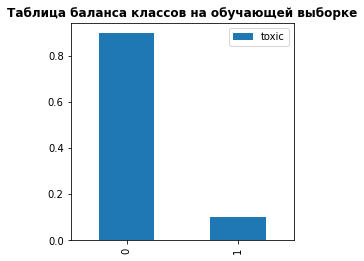

In [12]:
ttvc = target_train.value_counts(normalize=True).to_frame()
display(ttvc)
ttvc.plot(kind='bar', figsize=(4, 4))
plt.title('Таблица баланса классов на обучающей выборке', fontweight='bold');

,toxic
0,0.899138
1,0.100862


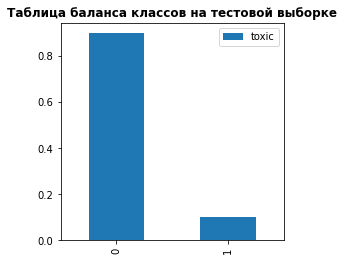

In [13]:
ttevc = target_test.value_counts(normalize=True).to_frame()
display(ttevc)
ttevc.plot(kind='bar', figsize=(4, 4))
plt.title('Таблица баланса классов на тестовой выборке', fontweight='bold');

**Наблюдается явный дисбаланс классов** на двух выборках. Если мы будем прогнозировать, что все комментарии негативные, то в почти **90%** будем правы. Чтобы этого избежать, применим технику **upsampling** и **downsampling** - увеличения и уменьшения меньшего и большего класса соответственно


**Техника `upsampling`:**

* Разделим обучающую выборку на отрицательные и положительные объекты;
* Скопируем несколько раз положительные объекты;
* С учётом полученных данных создадим новую обучающую выборку;
* Перемешаем данные

In [14]:
def upsample(features, target, repeat):
    
    features_zero = features[target==0]
    features_one = features[target==1]
    target_zero = target[target==0]
    target_one = target[target==1]
    
    features_upsampled = pd.concat([features_zero] + [features_one] * repeat)
    target_upsampled = pd.concat([target_zero] + [target_one] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled
    
features_upsampled, target_upsampled = upsample(features_train, target_train, 9)
display(target_upsampled.value_counts(normalize=True))

1    0.507572
0    0.492428
Name: toxic, dtype: float64

* Увеличили класс "1" в **9 раз**

**Методика уменьшения отрицательного класса**

* Разделяем обучающую выборку на отрицательные и положительные объекты;
* Случайным образом отбросываем часть из отрицательных объектов;
* С учётом полученных данных создаем новую обучающую выборку;
* Перемешиваем данные

In [15]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled
    
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.11)
display(target_downsampled.value_counts(normalize=True))

1    0.510111
0    0.489889
Name: toxic, dtype: float64

* Теперь создадим корпусы текстов, передав массив из значений признака `'lemm_text'` на разных выборках, сделав при этом **unicode** тип данных;
* Применим технику **TF-IDF** для векторизации, чтобы передать в дальнейшем моделяем на обучение

In [17]:
corpus_train = features_train['lemm_text'].values.astype('U')
corpus_test = features_test['lemm_text'].values.astype('U')
corpus_up = features_upsampled['lemm_text'].values.astype('U')
corpus_down = features_downsampled['lemm_text'].values.astype('U')

In [18]:
#corpus_train = features_train['lemm_text'].values.astype('U')

count_tfidf = TfidfVectorizer()

features_train_tfidf = count_tfidf.fit_transform(corpus_train)
features_test_tfidf = count_tfidf.transform(corpus_test)


display(features_train_tfidf.shape)
display(target_train.shape)
display(features_test_tfidf.shape)
target_test.shape

(35841, 64121)

(35841,)

(11947, 64121)

(11947,)

In [19]:
features_down_tfidf = count_tfidf.fit_transform(corpus_down)
features_test_down_tfidf = count_tfidf.transform(corpus_test)

print(f'DOWN: {features_down_tfidf.shape}, {target_downsampled.shape}')
print(f'test down: {features_test_down_tfidf.shape}, {target_test.shape}')

DOWN: (7220, 22038), (7220,)
test down: (11947, 22038), (11947,)


In [20]:
features_up_tfidf = count_tfidf.fit_transform(corpus_up)
features_test_up_tfidf = count_tfidf.transform(corpus_test)

print(f'UP: {features_up_tfidf.shape}, {target_upsampled.shape}')
print(f'test up: {features_test_up_tfidf.shape}, {target_test.shape}')

UP: (65305, 64121), (65305,)
test up: (11947, 64121), (11947,)


### Вывод

* Были успешно загружены данные;
* Рассмотрели данные при помощи функции `my_info()`;
* Далее загрузили библиотеку **spacy**, а также модель **en_core_web_sm**;
* Создали функции для очистки от лишних символов **clear_text(text)**, которую внедрили в анонимную функцию **lambda x**;
* Внутри этой функции мы лемматизировали и очистили текст, и **добавили** обратно в строку только те **токены**, которые **не являются стоп словами** с помощью метода `is_stop`;
* Сохранили файл с готовыми данными для обучения моделей в новой **csv** файле `lemmatized_toxic_comments2.csv`;
* Удалили не подходящие для дальнейшего анализа признаки;
* **Были урезаны данные**, чтобы модели смогли обучиться быстрее, но чтобы данных было достаточно, чтобы обучить качественную модель;
* **Разделили выборки** на обучающую и тестовую в размере **3:1**;
* Создали функции **upsample** и **downsample** для использования техники увеличения и уменьшения, чтобы сбалансировать классы;
* Создали корпусы текстов на выборках выборок, чтобы передать его на векторизацию;
* Произвели векторизацию при помощи класса **TfidfVectorizer()**

## Обучение

Теперь приступаем к обучению моделей

Параметры будем подбирать с помощью **GridSearchCV**

В задаче сказано, что для `обучения моделей классифицировать комментарии на позитивные и негативные применятся метрика` **f1**. Значение метрики **f1** должно быть `не меньше` **0.75**

* Создаем функцию для рассчитывания параметров и лучшего значения для **f1**. Считать будем при помощи **`GridSearchCV()`**. Эта техника обучает модель с заданными нами в перечни параметрами, из которых выберет лучшие для встроенной расчетной метрики **f1**, используя кросс валидацию, так как большая выборка (после проведем финальную проверку на тестовой). 


* Лучшее значение **f1** выводим с помощью атрибута `.best_score_`, а лучшие параметры с помощью `.best_params_`

На вход функция принимает **6 аргументов**: `сама модель`, `перечень параметров`, `признаки`, `целевой признак`, `название модели` и `примечание про использование баланса/дисбаланса`. С ее помощью мы найдем лучшие гиперпараметры для значения **f1**

In [21]:
def best_model(model, params, features, target, model_name, describe):
    
    cvs = GridSearchCV(model, params, scoring='f1', cv=5)
    
    cvs.fit(features, target)
    
    print(f'Лучшие параметры модели {model_name} {describe}: {cvs.best_params_}')
    print()
    print(f'Лучший f1 модели {model_name} {describe}: {round(abs(cvs.best_score_), 4)}')
    print()
    
    f1 = cvs.best_score_
    
    return f1

* Для проверки баланса предсказания, вводим функцию частоты `class_frequency` для подсчета относительных частот. Переводим таблицу в тип `Series`, чтобы смогла `value_counts(normalize=True)` выявить классы;


* Выводим **матрицу ошибок** `confusion_matrix` для проверки баланса

In [22]:
def class_frequency(model, features, target, model_name):
    
    model.fit(features, target)
    pred = model.predict(features)
    
    print(f'Относительные частоты модели {model_name} для проверки баланса:')
    print(pd.Series(pred).value_counts(normalize=True))
    print()
    print('Матрица ошибок для выявления баланса')
    print(confusion_matrix(target, pred))

### Сначала проверим, какое значение f1 выдают данные БЕЗ учета баланса

**Проверим `Логистическую Регрессию`**

In [23]:
%%time

model_lr = LogisticRegression(random_state=12345)

params_lr = {'solver': ['lbfgs', 'liblinear'], 'max_iter': range(1000, 1001)}

f1_lr_train = best_model(model_lr, params_lr, features_train_tfidf, target_train, 'Логистической Регрессии', '')
print(f1_lr_train)

Лучшие параметры модели Логистической Регрессии : {'max_iter': 1000, 'solver': 'liblinear'}

Лучший f1 модели Логистической Регрессии : 0.6214

0.6214096326583632
CPU times: user 40.3 s, sys: 57.1 s, total: 1min 37s
Wall time: 1min 37s


In [24]:
class_frequency(model_lr, features_train_tfidf, target_train, 'Логистической Регрессии (без учета баланса)')

Относительные частоты модели Логистической Регрессии (без учета баланса) для проверки баланса:
0    0.942775
1    0.057225
dtype: float64

Матрица ошибок для выявления баланса
[[32112    46]
 [ 1678  2005]]


* Наблюдаем, что при таком большом дисбалансе классов метрика **f1** показывает **малое значение**

Посмотрим, как поведет себя в случае установки баланса весов класса `class_weight='balanced'`

In [25]:
%%time

model_lr = LogisticRegression(class_weight='balanced', random_state=12345)

params_lr = {'solver': ['lbfgs', 'liblinear'], 'max_iter': range(1000, 1001)}

f1_lr_balanced = best_model(model_lr, params_lr, features_train_tfidf, target_train, 'Логистической Регрессии', '')
print(f1_lr_balanced)

Лучшие параметры модели Логистической Регрессии : {'max_iter': 1000, 'solver': 'lbfgs'}

Лучший f1 модели Логистической Регрессии : 0.7474

0.7474330756190717
CPU times: user 45.7 s, sys: 1min 3s, total: 1min 49s
Wall time: 1min 50s


In [26]:
class_frequency(model_lr, features_train_tfidf, target_train, 'Логистической Регрессии (при class_weight=balanced)')

Относительные частоты модели Логистической Регрессии (при class_weight=balanced) для проверки баланса:
0    0.872158
1    0.127842
dtype: float64

Матрица ошибок для выявления баланса
[[31172   986]
 [   87  3596]]


* Подмечаем, что значение **f1** сравнительно увеличилось. Правда, все еще **не подходит под критерии задачи**, и наблюдается все также дисбаланс

### С учетом баланса

**Рассмотрим модели Градиентного бустинга**.

Так как данные без учета баланса показывают маленькие значения, да и сам баланс предсказания слишком большой, то на них будем использовать только выборки, которые были увеличены **upsampled** и уменьшены **downsampled**. Проверим на выборках, выполненные этими техниками

Начнем с **LightGBMClassifier**

In [27]:
%%time

model_lgbm = LGBMClassifier(learning_rate=0.1, random_state=12345)

params_lgbm = {'n_estimators': range(1000, 1001)}

f1_lgbm_up = best_model(model_lgbm, params_lgbm, features_up_tfidf, target_upsampled, 'LGBMClassifier', 
                        'при увеличении объектов класса "1" техникой upsampling')
print(f1_lgbm_up)

In [29]:
class_frequency(model_lgbm, features_up_tfidf, target_upsampled, 'LGBMClassifier')

Видим, что соблюден баланс предсказывания, и матрица ошибок существенно поменялась в сторону баланса. И не можем заметить **большое** значение метрики **f1** (`проверял на уменьшенных данных датасета в 2 раза, там такой же результат, только обучается в 2-3 раза дольше`)

* Теперь на выборках, выполненных с **downsample**

In [30]:
%%time

model_lgbm = LGBMClassifier(learning_rate=0.1, random_state=12345)

params_lgbm = {'n_estimators': [900, 1000]}

f1_lgbm_down = best_model(model_lgbm, params_lgbm, features_down_tfidf, target_downsampled, 'LGBMClassifier', 
                          'при уменьшении отрицательного класса')
print(f1_lgbm_down)

Лучшие параметры модели LGBMClassifier при уменьшении отрицательного класса: {'n_estimators': 900}

Лучший f1 модели LGBMClassifier при уменьшении отрицательного класса: 0.8405

0.8404552618368479
CPU times: user 4min 57s, sys: 0 ns, total: 4min 57s
Wall time: 5min 1s


In [31]:
class_frequency(model_lgbm, features_down_tfidf, target_downsampled, 'LGBMClassifier')

Относительные частоты модели LGBMClassifier для проверки баланса:
0    0.53338
1    0.46662
dtype: float64

Матрица ошибок для выявления баланса
[[3443   94]
 [ 408 3275]]


Также видим соблюдение баланса классов и **большое** значение **f1**. И обучается в 3 раза быстрее

* Рассмотрим модель **CatBoostClassifier**

In [32]:
%%time

model_cbc = CatBoostClassifier(learning_rate=0.1, verbose=False, random_state=12345)

params_cbc = {'iterations': [150], 'max_depth': range(6, 7)}

f1_cbc_down = best_model(model_cbc, params_cbc, features_down_tfidf, target_downsampled, 'CatBoostRegressor', 
                         'при уменьшении отрицательного класса техникой downsampling')

Лучшие параметры модели CatBoostRegressor при уменьшении отрицательного класса техникой downsampling: {'iterations': 150, 'max_depth': 6}

Лучший f1 модели CatBoostRegressor при уменьшении отрицательного класса техникой downsampling: 0.8535

CPU times: user 2min 25s, sys: 0 ns, total: 2min 25s
Wall time: 2min 29s


In [33]:
class_frequency(model_cbc, features_down_tfidf, target_downsampled, 'CatBoostClassifier')

Относительные частоты модели CatBoostClassifier для проверки баланса:
1    0.509695
0    0.490305
dtype: float64

Матрица ошибок для выявления баланса
[[3537    0]
 [   3 3680]]


In [34]:
%%time

model_cbc = CatBoostClassifier(learning_rate=0.1, verbose=False, random_state=12345)

params_cbc = {'iterations': [150], 'max_depth': [6]}

f1_cbc_up = best_model(model_cbc, params_cbc, features_up_tfidf, target_upsampled, 'CatBoostRegressor', 
                       'при увеличении объектов класса "1" техникой upsampling')
print(f1_cbc_up)

Лучшие параметры модели CatBoostRegressor при увеличении объектов класса "1" техникой upsampling: {'iterations': 150, 'max_depth': 6}

Лучший f1 модели CatBoostRegressor при увеличении объектов класса "1" техникой upsampling: 0.8918

0.8918199164554259
CPU times: user 11min 40s, sys: 7.17 s, total: 11min 47s
Wall time: 12min 9s


In [35]:
class_frequency(model_cbc, features_up_tfidf, target_upsampled, 'CatBoostClassifier')

Относительные частоты модели CatBoostClassifier для проверки баланса:
1    0.514938
0    0.485062
dtype: float64

Матрица ошибок для выявления баланса
[[31668   490]
 [    9 33138]]


С выборками, выполненные методикой `downsample`, обучение проиходит гораздо быстрее, нежели на увеличенных. Но и значения метрики **f1** меньше, но тут не так значительно. Но не можем выделить скорость при этом, `процесс` проходит `намного быстрее`

* Модели **LogisticRegression** были обучены без учета баланса. Сейчас посмотрим, как ведут себя они с учетом баланса на разных выборках `unsampled` и `downsampled`

In [36]:
%%time

model_lr = LogisticRegression(random_state=12345)

params_lr = {'solver': ['lbfgs', 'liblinear'], 'max_iter': [500, 1000]}

f1_lr_up = best_model(model_lr, params_lr, features_up_tfidf, target_upsampled, 'Логистической Регрессии', 
                      'при увеличении объектов класса "1" техникой upsampling')
print(f1_lr_up)

Лучшие параметры модели Логистической Регрессии при увеличении объектов класса "1" техникой upsampling: {'max_iter': 500, 'solver': 'lbfgs'}

Лучший f1 модели Логистической Регрессии при увеличении объектов класса "1" техникой upsampling: 0.9706

0.9705684917595405
CPU times: user 2min 42s, sys: 3min 32s, total: 6min 15s
Wall time: 6min 18s


In [37]:
class_frequency(model_lr, features_up_tfidf, target_upsampled, 'Логистической Регрессии (upsampled)')

Относительные частоты модели Логистической Регрессии (upsampled) для проверки баланса:
1    0.5163
0    0.4837
dtype: float64

Матрица ошибок для выявления баланса
[[31300   858]
 [  288 32859]]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Очень большое** значение **f1** (также проверял на данных, которые уменьшены не в 3 раза, а в 2, и получается примерно такое же значение. Только снова обучение в 2-3 раза дольше)

In [38]:
%%time

model_lr = LogisticRegression(random_state=12345)

params_lr = {'solver': ['lbfgs', 'liblinear'], 'max_iter': [500, 1000]}

f1_lr_down = best_model(model_lr, params_lr, features_down_tfidf, target_downsampled, 'Логистической Регрессии', 
                        'при уменьшении отрицательного класса техникой downsampling')
print(f1_lr_down)

Лучшие параметры модели Логистической Регрессии при уменьшении отрицательного класса техникой downsampling: {'max_iter': 500, 'solver': 'lbfgs'}

Лучший f1 модели Логистической Регрессии при уменьшении отрицательного класса техникой downsampling: 0.8668

0.8667969120099187
CPU times: user 24 s, sys: 33 s, total: 57 s
Wall time: 57.1 s


In [39]:
class_frequency(model_lr, features_down_tfidf, target_downsampled, 'Логистической Регрессии (downsampled)')

Относительные частоты модели Логистической Регрессии (downsampled) для проверки баланса:
0    0.50554
1    0.49446
dtype: float64

Матрица ошибок для выявления баланса
[[3410  127]
 [ 240 3443]]


Снова наблюдаем тенденцию скорости и чуть-чуть ухудшение метрики

### Вывод

* Были обучены модели **LogisticRegression**, **LightLGBM** и **CatBoostRegression**;
* Модель **LogisticRegression** была проверена на обучающей выборке без учета баланса. Результат показал малое значение метрики **f1**;
* Моделям Градиентного бустинга были подобраны гиперпарпараметры и обучены с учетом баланса (либо увеличением положительного класса **upsample**, либо уменешением отрицательного класса **downsample**;
* Значение качества **f1** лучше у моделей, которые выборки обучены техникой **upsample**;
* Скорость обучения при этом намного ниже, нежели у моделей на **downsample**
* Лучше всех себя показала модель **LightGBMClassifier** на **upsample** выборках. Значение **f1** `0.98`;
* Для визуальной демонстрации обучения моделей, выведем результат в общий датафрейм

In [40]:
table = pd.DataFrame({'модель':['LogisticRegression', 'LogisticRegression (class_weight=balanced)', 
                                'LogisticRegression (upsampled)', 'LogisticRegression (downsampled)', 
                                'CatBoostClassifier (upsampled)', 'CatBoostClassifier (downsampled)', 
                                'LGBMClassifier (upsampled)', 'LGBMCLassifier (downsampled)'], 
                      '~ время обучения и предсказания (мин.)': [1.1, 1.08, 4.59, 0.36, 2.18, 12.05, 41.39, 4.33], 
                      'f1': [round(f1_lr_train, 4), round(f1_lr_balanced, 4), round(f1_lr_up, 4), 
                             round(f1_lr_down, 4), round(f1_cbc_up, 4), round(f1_cbc_down, 4), 
                             0.9860, round(f1_lgbm_down, 4)]})

table

,модель,~ время обучения и предсказания (мин.),f1
0,LogisticRegression,1.10,0.6214
1,LogisticRegression (class_weight=balanced),1.08,0.7474
2,LogisticRegression (upsampled),4.59,0.9706
3,LogisticRegression (downsampled),0.36,0.8668
4,CatBoostClassifier (upsampled),2.18,0.8918
5,CatBoostClassifier (downsampled),12.05,0.8535
6,LGBMClassifier (upsampled),41.39,0.9860
7,LGBMCLassifier (downsampled),4.33,0.8405


## Финальное тестирование

Теперь проведем финальное тестирование на лучших моделях с помощью тестовых выборках

* Модель **LogisticRegression** на **upsampled** выборках

In [41]:
%%time

model_lr = LogisticRegression(solver='lbfgs', max_iter=500, random_state=12345)
model_lr.fit(features_up_tfidf, target_upsampled)

CPU times: user 13.7 s, sys: 18.3 s, total: 31.9 s
Wall time: 32 s


LogisticRegression(max_iter=500, random_state=12345)

In [42]:
%%time

predict_lr_final = model_lr.predict(features_test_up_tfidf)
f1_lr_final = f1_score(target_test, predict_lr_final)
print(f1_lr_final)

0.7163608562691132
CPU times: user 8.95 ms, sys: 4.89 ms, total: 13.8 ms
Wall time: 6.16 ms


* Модель **LGBMClassifier** на `upsampled` выборках

In [43]:
%%time

model_lgbm = LGBMClassifier(learning_rate=0.1, n_estimators=1000, random_state=12345)

model_lgbm.fit(features_up_tfidf, target_upsampled)

CPU times: user 5min 14s, sys: 762 µs, total: 5min 14s
Wall time: 5min 16s


LGBMClassifier(n_estimators=1000, random_state=12345)

In [44]:
%%time

predict_lgbm_test = model_lgbm.predict(features_test_up_tfidf)
f1_lgbm_final = f1_score(target_test, predict_lgbm_test)
print(f1_lgbm_final)

0.7611749680715197
CPU times: user 2.52 s, sys: 3.84 ms, total: 2.53 s
Wall time: 2.54 s


* Модель **CatBoostClassifier** на `upsampled` выборках

In [45]:
%%time

model_cbc = CatBoostClassifier(learning_rate=0.1, iterations=150, max_depth=6, verbose=False, random_state=12345)
model_cbc.fit(features_up_tfidf, target_upsampled)
predict_cbc_test = model_cbc.predict(features_test_up_tfidf)
f1_cbc_final = f1_score(target_test, predict_cbc_test)
print(f1_cbc_final)

0.7125097125097124
CPU times: user 2min 17s, sys: 1.47 s, total: 2min 18s
Wall time: 2min 19s


По аналогии с общими результатами, внесем финальные значения в общий датафрейм

In [46]:
final_table = pd.DataFrame({'модель': ['LogisticRegression (upsampled)', 'CatBoostClassifier (upsampled)', 
                                       'LGBMClassifier (upsampled)'], 
                            '~ время обучения и предсказания (мин.)': [0.43, 2.21, 5.29], 
                            'финальное f1': [round(f1_lr_final, 4), round(f1_cbc_final, 4), round(f1_lgbm_final, 4)]})

final_table

,модель,~ время обучения и предсказания (мин.),финальное f1
0,LogisticRegression (upsampled),0.43,0.7164
1,CatBoostClassifier (upsampled),2.21,0.7125
2,LGBMClassifier (upsampled),5.29,0.7612


**По критерияем задачи подходит модель `LGBMClassifier (upsampled)`**

Для окончательного вывода стоит проверить на адекватность выявленную финальную модель `LGBMClassifier (upsampled)`, которая **подходит по критериям поставленной задачи, то есть значением `f1`** 


Считаем значение метрики `accuracy_score` на модели **LGBMClassifier (upsampled)** и вводим `констатную accuracy` для проверки на адекватность, а также `константное` значение `f1`:

In [49]:
predict_lgbm_acc = model_lgbm.predict(features_up_tfidf)
final_acc = accuracy_score(target_upsampled, predict_lgbm_acc)
print(final_acc)

0.9981471556542378


In [50]:
F1_CONST = 0.75
constant = pd.Series(0, index=target.index)
accuracy_constant = accuracy_score(target, constant)
print(f'Константа: {accuracy_constant}')
print()

if accuracy_constant < final_acc >= F1_CONST:
    print('Выявленная модель прошла тест на адекватность и подходит по критериям задачи')
else:
    print('Что-то пошло не так')

Константа: 0.8977149075081611

Выявленная модель прошла тест на адекватность и подходит по критериям задачи


In [54]:
final_table.loc[final_table['модель'] == 'LGBMClassifier (upsampled)', :]

,модель,~ время обучения и предсказания (мин.),финальное f1
2,LGBMClassifier (upsampled),5.29,0.7612


## Вывод

* Были загружены и разобраны данные;
* Была произведена лемматизация с помощью библиотеки **spacy** модели **en_core_web_sm**;
* Также была произведена очистка от лишних символов;
* Избавились от стоп слов. **Были добавили** обратно в строку только те **токены**, которые **не являются стоп словами** с помощью метода `is_stop`;
* **Были урезаны данные**, чтобы модели смогли обучиться быстрее, но чтобы данных было достаточно, чтобы обучить качественную модель;
* Создали функции **upsample** и **downsample** для использования техники увеличения и уменьшения, чтобы сбалансировать классы;
* Была произведена векторизация при помощи **TfidfVectorizer()**;
* С помощью техники **GridSearchCV** обучали разные модели на разных выборках и подбирали гиперпараметры: `LogisticRegression`, `LightGBMClassifier` и `CatBoostClassifier`;
* В ходе анализа, были подобраны лучшие гиперпараметры моделям с разными выборками для метрики **f1**;
* Были обнаружены лучшие значения метрики **f1** на `upsampled` выборках: `LogisticRegression (upsampled)`, `LightGBMClassifier (upsampled)` и `CatBoostClassifier (upsampled)`;
* Лучшие модели с **f1** значением были проверены на тестовой выборке;
* Из трех выявленных моделей нужное значение **f1** показала только модель `LightGBMClassifier (upsampled)`. Она была проверена на адекватность


Выведем общий датасет для визуализации результатов **(до финальной проверки)**

In [55]:
table

,модель,~ время обучения и предсказания (мин.),f1
0,LogisticRegression,1.10,0.6214
1,LogisticRegression (class_weight=balanced),1.08,0.7474
2,LogisticRegression (upsampled),4.59,0.9706
3,LogisticRegression (downsampled),0.36,0.8668
4,CatBoostClassifier (upsampled),2.18,0.8918
5,CatBoostClassifier (downsampled),12.05,0.8535
6,LGBMClassifier (upsampled),41.39,0.9860
7,LGBMCLassifier (downsampled),4.33,0.8405


**После финальной проверки**

In [56]:
final_table

,модель,~ время обучения и предсказания (мин.),финальное f1
0,LogisticRegression (upsampled),0.43,0.7164
1,CatBoostClassifier (upsampled),2.21,0.7125
2,LGBMClassifier (upsampled),5.29,0.7612


**Лучшая модель**

In [64]:
final_table.loc[final_table['модель'] == 'LGBMClassifier (upsampled)', :]

,модель,~ время обучения и предсказания (мин.),финальное f1
2,LGBMClassifier (upsampled),5.29,0.7612


**Интернет-магазин `«Викишоп»` может использовать эту модель для поиска токсичных комментариев и отправлять их на модерацию**